In [1]:
# import required packages
from imodels import get_clean_dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imodels.tree.rf_plus.rf_plus.rf_plus_models import RandomForestPlusClassifier
from imodels.tree.rf_plus.feature_importance.rfplus_explainer import RFPlusMDI
from subgroup_detection import *
import warnings
import shap
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
np.random.seed(0)

In [3]:
# get pre-cleaned compas dataset from imodels
X, y, feature_names = get_clean_dataset('compas_two_year_clean', data_source='imodels')
X = pd.DataFrame(X, columns=feature_names)

In [4]:
# the propublica study narrowed the dataset to only African-American and
# Caucasian defendants, and doing so keeps the vast majority of the data,
# so we will do the same.
y = y[(X['race:African-American'] == 1) | (X['race:Caucasian'] == 1)]
X = X[(X['race:African-American'] == 1) | (X['race:Caucasian'] == 1)]

# now that we have narrowed the dataset, we should remove the one-hot encodings
# of variables that are consistently zero, such as the other ethnicities.
# we also drop age because the binned 'age category' is preferred here.
X = X.drop(["race:Asian", "race:Hispanic", "race:Native_American",
            "race:Other", "age"], axis = 1)

# Introduction
## About the Dataset
Throughout this report, we will be looking at the pre-cleaned version of `COMPAS` dataset from the `imodels` package. Each row in this dataset represents an incarcerated individual in Broward County, FL. The task is to predict whether each individual will recommit a crime within two years of release from custody. We take a peek at the data below:

In [5]:
X.head()

,priors_count,days_b_screening_arrest,c_jail_time,juv_fel_count,juv_other_count,juv_misd_count,c_charge_degree:F,c_charge_degree:M,race:African-American,race:Caucasian,age_cat:25_-_45,age_cat:Greater_than_45,age_cat:Less_than_25,sex:Female,sex:Male
1,0.0,-1.0,10.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,4.0,-1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4,14.0,-1.0,6.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
6,0.0,-1.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
7,0.0,-1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [6]:
print("Dimensions of the COMPAS Dataset (Covariates):", X.shape)
print("Dimensions of the Response:", y.shape)

Dimensions of the COMPAS Dataset (Covariates): (5278, 15)
Dimensions of the Response: (5278,)


Before we begin analyzing our data, we first perform some simple exploratory data analysis.

In [7]:
print("---------------------------------------------")
print("The Average # of Priors for Non-Recidivists is:",
      round(X['priors_count'][y==0].mean(), 2))
print("The Average # of Priors for Recidivists is:",
      round(X['priors_count'][y==1].mean(), 2))
print("---------------------------------------------")
print("The Average # of Days Before Screening Arrest for Non-Recidivists is:",
      round(X['days_b_screening_arrest'][y==0].mean(), 2))
print("The Average # of Days Before Screening Arrest for Recidivists is:",
      round(X['days_b_screening_arrest'][y==1].mean(), 2))
print("---------------------------------------------")
print("The Average # of Days in Jail for Non-Recidivists is:",
      round(X['c_jail_time'][y==0].mean(), 2))
print("The Average # of Days in Jail for Recidivists is:",
      round(X['c_jail_time'][y==1].mean(), 2))
print("---------------------------------------------")
print("The Average # of Juvenile Felony Counts for Non-Recidivists is:",
      round(X['juv_fel_count'][y==0].mean(), 2))
print("The Average # of Juvenile Felony Counts for Recidivists is:",
      round(X['juv_fel_count'][y==1].mean(), 2))
print("---------------------------------------------")
print("The Average # of Other Juvenile Counts for Non-Recidivists is:",
      round(X['juv_other_count'][y==0].mean(), 2))
print("The Average # of Other Juvenile Counts for Recidivists is:",
      round(X['juv_other_count'][y==1].mean(), 2))
print("---------------------------------------------")
print("The Average # of Juvenile Misdemeanor Counts for Non-Recidivists is:",
      round(X['juv_misd_count'][y==0].mean(), 2))
print("The Average # of Juvenile Misdemeanor Counts for Recidivists is:",
      round(X['juv_misd_count'][y==1].mean(), 2))
print("---------------------------------------------")
print("The Probability of Felony Charge for Non-Recidivists is:",
      round(X['c_charge_degree:F'][y==0].mean(), 2))
print("The Probability of Felony Charge for Recidivists is:",
      round(X['c_charge_degree:F'][y==1].mean(), 2))
print("---------------------------------------------")
print("The Probability of Being a Recidivist Given African-American Race:",
      round(y[X['race:African-American']==1].mean(), 2))
print("The Probability of Being a Recidivist Given Caucasian Race:",
      round(y[X['race:Caucasian']==1].mean(), 2))
print("---------------------------------------------")
print("The Probability of Being a Recidivist Given Age Between 25 & 45:",
      round(y[X['age_cat:25_-_45']==1].mean(), 2))
print("The Probability of Being a Recidivist Given Age Over 45:",
      round(y[X['age_cat:Greater_than_45']==1].mean(), 2))
print("The Probability of Being a Recidivist Given Age Under 25:",
      round(y[X['age_cat:Less_than_25']==1].mean(), 2))
print("---------------------------------------------")
print("The Probability of Recidivism Given Male Gender:", round(y[X['sex:Male']==1].mean(), 2))
print("The Probability of Recidivism Given Female Gender:", round(y[X['sex:Female']==1].mean(), 2))
print("---------------------------------------------")

---------------------------------------------
The Average # of Priors for Non-Recidivists is: 2.04
The Average # of Priors for Recidivists is: 4.87
---------------------------------------------
The Average # of Days Before Screening Arrest for Non-Recidivists is: -2.11
The Average # of Days Before Screening Arrest for Recidivists is: -1.36
---------------------------------------------
The Average # of Days in Jail for Non-Recidivists is: 9.92
The Average # of Days in Jail for Recidivists is: 20.29
---------------------------------------------
The Average # of Juvenile Felony Counts for Non-Recidivists is: 0.02
The Average # of Juvenile Felony Counts for Recidivists is: 0.1
---------------------------------------------
The Average # of Other Juvenile Counts for Non-Recidivists is: 0.05
The Average # of Other Juvenile Counts for Recidivists is: 0.18
---------------------------------------------
The Average # of Juvenile Misdemeanor Counts for Non-Recidivists is: 0.04
The Average # of Juv

It is apparent that while multiple variables might impact the medical expenses of an individual, the most eye-popping difference is the average expense difference between smokers and non-smokers.

Now, we split the data into training and testing datasets using a 70/30 split. We check for covariate balance in our train/test split below. We do not include `region` in this covariate balance check for the sake of brevity.

In [8]:
# split data into training and testing sets
# we won't actually use the test set here though, since 'discovery' would be
# a post-hoc analysis in real life
# proportion of training data is small so rf+ can fit without taking hours
y = np.asarray(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)

In [9]:
print("---------------------------------------------")
print("Number of Observations in Training Data:", X_train.shape[0])
print("Number of Observations in Testing Data:", X_test.shape[0])
print("---------------------------------------------")
print("Average # of Priors in Training Data:", X_train['priors_count'].mean())
print("Average # of Priors in Testing Data:", X_test['priors_count'].mean())
print("---------------------------------------------")
print("Average # of Days Before Screening Arrest in Training Data:", X_train['days_b_screening_arrest'].mean())
print("Average # of Days Before Screening Arrest in Testing Data:", X_test['days_b_screening_arrest'].mean())
print("---------------------------------------------")
print("Average # of Days in Jail in Training Data:", X_train['c_jail_time'].mean())
print("Average # of Days in Jail in Testing Data:", X_test['c_jail_time'].mean())
print("---------------------------------------------")
print("Average # of Juvenile Felony Counts in Training Data:", X_train['juv_fel_count'].mean())
print("Average # of Juvenile Felony Counts in Testing Data:", X_test['juv_fel_count'].mean())
print("---------------------------------------------")
print("Average # of Other Juvenile Counts in Training Data:", X_train['juv_other_count'].mean())
print("Average # of Other Juvenile Counts in Testing Data:", X_test['juv_other_count'].mean())
print("---------------------------------------------")
print("Average # of Juvenile Misdemeanor Counts in Training Data:", X_train['juv_misd_count'].mean())
print("Average # of Juvenile Misdemeanor Counts in Testing Data:", X_test['juv_misd_count'].mean())
print("---------------------------------------------")
print("Probability of Felony Charge in Training Data:", X_train['c_charge_degree:F'].mean())
print("Probability of Felony Charge in Testing Data:", X_test['c_charge_degree:F'].mean())
print("---------------------------------------------")
print("Proportion of African-American Defendants in Training Data:", X_train['race:African-American'].mean())
print("Proportion of African-American Defendants in Testing Data:", X_test['race:African-American'].mean())
print("---------------------------------------------")
print("Proportion of Caucasian Defendants in Training Data:", X_train['race:Caucasian'].mean())
print("Proportion of Caucasian Defendants in Testing Data:", X_test['race:Caucasian'].mean())
print("---------------------------------------------")
print("Proportion of Defendants Between Ages 25 & 45 in Training Data:", X_train['age_cat:25_-_45'].mean())
print("Proportion of Defendants Between Ages 25 & 45 in Testing Data:", X_test['age_cat:25_-_45'].mean())
print("---------------------------------------------")
print("Proportion of Defendants Over Age 45 in Training Data:", X_train['age_cat:Greater_than_45'].mean())
print("Proportion of Defendants Over Age 45 in Testing Data:", X_test['age_cat:Greater_than_45'].mean())
print("---------------------------------------------")
print("Proportion of Defendants Under Age 25 in Training Data:", X_train['age_cat:Less_than_25'].mean())
print("Proportion of Defendants Under Age 25 in Testing Data:", X_test['age_cat:Less_than_25'].mean())
print("---------------------------------------------")
print("Proportion of Women in Training Data:", X_train['sex:Female'].mean())
print("Proportion of Women in Testing Data:", X_test['sex:Female'].mean())
print("---------------------------------------------")
print("Probability of Recidivism in Training Data:", y_train.mean())
print("Probability of Recidivism in Testing Data:", y_test.mean())
print("---------------------------------------------")

---------------------------------------------
Number of Observations in Training Data: 3694
Number of Observations in Testing Data: 1584
---------------------------------------------
Average # of Priors in Training Data: 3.4948566
Average # of Priors in Testing Data: 3.3838384
---------------------------------------------
Average # of Days Before Screening Arrest in Training Data: -1.7818084
Average # of Days Before Screening Arrest in Testing Data: -1.6085858
---------------------------------------------
Average # of Days in Jail in Training Data: 14.9269085
Average # of Days in Jail in Testing Data: 15.573233
---------------------------------------------
Average # of Juvenile Felony Counts in Training Data: 0.06578235
Average # of Juvenile Felony Counts in Testing Data: 0.051136363
---------------------------------------------
Average # of Other Juvenile Counts in Training Data: 0.123443425
Average # of Other Juvenile Counts in Testing Data: 0.109217174
------------------------------

The train and test datasets seem reasonable, so we continue with our analysis.
# Baseline 'Global' Model
We begin by fitting a RF+ to the training data. The accuracy, AUROC, AUPRC, and F1 on the test data is reported below. The total number misclassified is also reported, as we will use this to compare the 'global' model fit on all of the data to the 'local' models fit on each cluster. We also report the results of a simple logistic regression model, as we will fit logistic regression models to the clusters to determine if splitting into subgroups makes the decision rule easier. However, we will see that logistic regression outperforms RF+ on this task, so perhaps this is not the best dataset to do this with.

In [10]:
# fit RF+ model
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
rf_plus = RandomForestPlusClassifier(rf, prediction_model = LogisticRegression())
rf_plus.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   25.3s finished


In [11]:
# fit logistic model
log = LogisticRegression(random_state=0, max_iter=1000)
log.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [12]:
# compute accuracy and # misclassified on the test set
y_pred = rf_plus.predict(X_test)
global_acc = np.mean(y_test == y_pred)
print(f'RF+ Test Set Accuracy: {np.mean(y_test == y_pred)}')
global_misclassified = np.sum(y_test != y_pred)
print(f'RF+ Test Set # Misclassified: {np.sum(y_test != y_pred)}')
# compute auroc, auprc, and f1 score on test set
y_pred_prob = rf_plus.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred_prob)
auprc = average_precision_score(y_test, y_pred_prob)
f1 = f1_score(y_test, y_pred)
print(f'RF+ Test Set AUROC: {auroc}')
print(f'RF+ Test Set AUPRC: {auprc}')
print(f'RF+ Test Set F1 Score: {f1}')
print('---------------------------------------------')
print("Logistic Test Set Accuracy:", log.score(X_test, y_test))
print("Logistic Test Set # Misclassified:", np.sum(y_test != log.predict(X_test)))
# compute auroc, auprc, and f1 score on test set
y_pred_prob = log.predict_proba(X_test)[:, 1]
auroc = roc_auc_score(y_test, y_pred_prob)
auprc = average_precision_score(y_test, y_pred_prob)
f1 = f1_score(y_test, y_pred)
print(f'Logistic Test Set AUROC: {auroc}')
print(f'Logistic Test Set AUPRC: {auprc}')
print(f'Logistic Test Set F1 Score: {f1}')

RF+ Test Set Accuracy: 0.6275252525252525
RF+ Test Set # Misclassified: 590
RF+ Test Set AUROC: 0.6820367523221395
RF+ Test Set AUPRC: 0.6682569037944643
RF+ Test Set F1 Score: 0.6103038309114928
---------------------------------------------
Logistic Test Set Accuracy: 0.6628787878787878
Logistic Test Set # Misclassified: 534
Logistic Test Set AUROC: 0.7149868901194243
Logistic Test Set AUPRC: 0.7064967979499193
Logistic Test Set F1 Score: 0.6103038309114928


In the following sections, we will compute subgroups using the RF/RF+ fit on the training data. We will then assign each test point to these subgroups using various methods. This will give us clusters that are composed of both training and testing points, allowing us to fit separate RF/RF+'s to the training data in each of these subgroups and predict the testing data. This will allow us to compare the TSE of the global model to the summed TSEs of the 'local' models fit on the clusters. Intuitively, the drop in TSE acheived in the local models will be directly related to how 'accurate' the subgroups determined by local feature importance are.

When clustering our data, we will compute the ranking-based overlap (RBO) between each pair of points, and then use this as the distance matrix for hierarchical clustering with Ward linkage. The number of clusters will be chosen based on the appearance of the heatmap. It may be worth trying this with a range of cluster amounts and checking how it changes model performance - we could perhaps make a train/validate/test split, where we choose the number of clusters that results in the lowest total squared error in the 'local' models (or perhaps make an elbow plot, since the performance should only improve as # of clusters increases).

# Local MDI+

To detect subgroups using Local MDI+, we convert the Local MDI+ scores to feature rankings, and then compute RBO, as described above. We compute LMDI+ for the training points by using $metric(y_i, \hat{y}^{(k)}_i)$. The resulting clusters can be visualized below.

In [14]:
# get feature importances
mdi_explainer = RFPlusMDI(rf_plus)
mdi = mdi_explainer.explain_linear_partial(np.asarray(X_train), y_train)
mdi_rankings = mdi_explainer.get_rankings(mdi)

In [15]:
# get rbo distance matrix
rbo_train = compute_rbo_matrix(mdi_rankings, form = 'distance')

array([[0.        , 0.55742876, 0.44754199, ..., 0.52776019, 0.47897967,
        0.50295596],
       [0.55742876, 0.        , 0.56299939, ..., 0.38079048, 0.26492448,
        0.3456257 ],
       [0.44754199, 0.56299939, 0.        , ..., 0.58235487, 0.5821001 ,
        0.59286178],
       ...,
       [0.52776019, 0.38079048, 0.58235487, ..., 0.        , 0.25694213,
        0.15314445],
       [0.47897967, 0.26492448, 0.5821001 , ..., 0.25694213, 0.        ,
        0.23225884],
       [0.50295596, 0.3456257 , 0.59286178, ..., 0.15314445, 0.23225884,
        0.        ]])

In [16]:
mdi_copy = pd.DataFrame(mdi, columns=X_train.columns).copy()
num_clusters = 4
clusters = assign_training_clusters(mdi_copy, rbo_train, num_clusters)

ValueError: The matrix argument must be square.

It is easy to see that these subgroups differ in feature importance, as shown above. However, just because they differ in feature importance does not necessarily imply that they differ in the values of those features themselves. We now check some useful summary statistics for each cluster to better understand how we have grouped the data.

In [16]:
print("---------------------------------------------")
# calculate average charge for each cluster
for i in range(num_clusters):
    print(f"Proportion of Data in Cluster #{i+1}:",
          X_train[clusters==i+1].shape[0]/X_train.shape[0])
print("---------------------------------------------")
# get average number of priors in each cluster
for i in range(num_clusters):
    print(f"Average # of Priors in Cluster #{i+1}:",
          X_train[clusters==i+1]['priors_count'].mean())
print("---------------------------------------------")
# get average # of days before screening arrest in each cluster
for i in range(num_clusters):
    print(f"Average # of Days Before Screening Arrest in Cluster #{i+1}:",
          X_train[clusters==i+1]['days_b_screening_arrest'].mean())
print("---------------------------------------------")
# get average jail time in each cluster
for i in range(num_clusters):
    print(f"Average Jail Time (Days) in Cluster #{i+1}:",
          X_train[clusters==i+1]['c_jail_time'].mean())
print("---------------------------------------------")
# get average # of juvenile felony counts in each cluster
for i in range(num_clusters):
    print(f"Average # of Juvenile Felony Counts in Cluster #{i+1}:",
          X_train[clusters==i+1]['juv_fel_count'].mean())
print("---------------------------------------------")
# get average number juvenile 'other' counts in each cluster
for i in range(num_clusters):
    print(f"Average # of Juvenile 'Other' Counts in Cluster #{i+1}:",
          X_train[clusters==i+1]['juv_other_count'].mean())
print("---------------------------------------------")
# get average number of juvenile misdemeanor counts in each cluster
for i in range(num_clusters):
    print(f"Average # of Juvenile Misdemeanor Counts in Cluster #{i+1}:",
          X_train[clusters==i+1]['juv_misd_count'].mean())
print("---------------------------------------------")
# get probability of felony charge in each cluster
for i in range(num_clusters):
    print(f"Probability of Felony Charge in Cluster #{i+1}:",
          X_train[clusters==i+1]['c_charge_degree:F'].mean())
print("---------------------------------------------")
# get proportion of African-American defendants in each cluster
for i in range(num_clusters):
    print(f"Proportion of African-American Defendants in Cluster #{i+1}:",
          X_train[clusters==i+1]['race:African-American'].mean())
print("---------------------------------------------")
# get proportion of age 25-45 in each cluster
for i in range(num_clusters):
    print(f"Proportion of Defendants Aged 25-45 in Cluster #{i+1}:",
          X_train[clusters==i+1]['age_cat:25_-_45'].mean())
print("---------------------------------------------")
# get proportion of age over 45 in each cluster
for i in range(num_clusters):
    print(f"Proportion of Defendants Over Age 45 in Cluster #{i+1}:",
          X_train[clusters==i+1]['age_cat:Greater_than_45'].mean())
print("---------------------------------------------")
# get proportion of age under 25 in each cluster
for i in range(num_clusters):
    print(f"Proportion of Defendants Under Age 25 in Cluster #{i+1}:",
          X_train[clusters==i+1]['age_cat:Less_than_25'].mean())
print("---------------------------------------------")
# get proportion of men in each cluster
for i in range(num_clusters):
    print(f"Proportion of Men in Cluster #{i+1}:",
          X_train[clusters==i+1]['sex:Male'].mean())
# get proportion of smokers in each cluster
for i in range(num_clusters):
    print(f"Probability of Recidivism in Cluster #{i+1}:",
          y_train[clusters==i+1].mean())
print("---------------------------------------------")

---------------------------------------------
Proportion of Data in Cluster #1: 0.4648077964266378
Proportion of Data in Cluster #2: 0.17569030860855442
Proportion of Data in Cluster #3: 0.10341093665403357
Proportion of Data in Cluster #4: 0.2560909583107742
---------------------------------------------
Average # of Priors in Cluster #1: 4.2312174
Average # of Priors in Cluster #2: 2.890601
Average # of Priors in Cluster #3: 3.0183246
Average # of Priors in Cluster #4: 2.7653277
---------------------------------------------
Average # of Days Before Screening Arrest in Cluster #1: -1.3750728
Average # of Days Before Screening Arrest in Cluster #2: -2.3066256
Average # of Days Before Screening Arrest in Cluster #3: -1.9371728
Average # of Days Before Screening Arrest in Cluster #4: -2.0972517
---------------------------------------------
Average Jail Time (Days) in Cluster #1: 13.998253
Average Jail Time (Days) in Cluster #2: 12.080123
Average Jail Time (Days) in Cluster #3: 15.83246
Av

## Evaluating Cluster Performance - Centroid Method w/ Exact Mean
Now that we have a good idea of what our clustering has done, we can check if this helps improve our predictions. We compute LMDI+ of test points using $metric(\hat{y}_i, \hat{y}^{(k)}_i)$. We will take the test points and determine their cluster membership based on their RBO similarity to the mean point in each cluster (in RBO embedding). We will then fit a RF+ on the training data and using it to predict the test data for that cluster. We can then compute the R^2 and total squared error for each cluster's model. By summing the TSE across cluster models and comparing this to the original TSE reported above, we can get a good idea of how well these clusters improve model accuracy.

In [17]:
# get mdi rankings assignments for test points
mdi_test, partial_preds_test = mdi_explainer.explain(np.asarray(X_test))
mdi_test_rankings = mdi_explainer.get_rankings(mdi_test)

In [18]:
test_clust = assign_testing_clusters(method = "centroid", median_approx = False,
                                     rbo_distance_matrix = rbo_train,
                                     lfi_train_ranking = mdi_rankings,
                                     lfi_test_ranking = mdi_test_rankings,
                                     clusters = clusters)

In [19]:
cluster1_trainX = X_train[clusters == 1]
cluster2_trainX = X_train[clusters == 2]
cluster3_trainX = X_train[clusters == 3]
cluster4_trainX = X_train[clusters == 4]

cluster1_trainy = y_train[clusters == 1]
cluster2_trainy = y_train[clusters == 2]
cluster3_trainy = y_train[clusters == 3]
cluster4_trainy = y_train[clusters == 4]

cluster1_testX = X_test[test_clust == 1]
cluster2_testX = X_test[test_clust == 2]
cluster3_testX = X_test[test_clust == 3]
cluster4_testX = X_test[test_clust == 4]

cluster1_testy = y_test[test_clust == 1]
cluster2_testy = y_test[test_clust == 2]
cluster3_testy = y_test[test_clust == 3]
cluster4_testy = y_test[test_clust == 4]

In [20]:
print("---------------------------------------------")
# calculate average charge for each cluster
for i in range(num_clusters):
    print(f"Proportion of Train Data in Cluster #{i+1}:",
          X_train[clusters==i+1].shape[0]/X_train.shape[0])
    print(f"Proportion of Test Data in Cluster #{i+1}:",
          X_test[test_clust==i+1].shape[0]/X_test.shape[0])
print("---------------------------------------------")
# get average number of priors in each cluster
for i in range(num_clusters):
    print(f"Average # of Priors in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['priors_count'].mean())
    print(f"Average # of Priors in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['priors_count'].mean())
print("---------------------------------------------")
# get average # of days before screening arrest in each cluster
for i in range(num_clusters):
    print(f"Average # of Days Before Screening Arrest in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['days_b_screening_arrest'].mean())
    print(f"Average # of Days Before Screening Arrest in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['days_b_screening_arrest'].mean())
print("---------------------------------------------")
# get average jail time in each cluster
for i in range(num_clusters):
    print(f"Average Jail Time (Days) in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['c_jail_time'].mean())
    print(f"Average Jail Time (Days) in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['c_jail_time'].mean())
print("---------------------------------------------")
# get average # of juvenile felony counts in each cluster
for i in range(num_clusters):
    print(f"Average # of Juvenile Felony Counts in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['juv_fel_count'].mean())
    print(f"Average # of Juvenile Felony Counts in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['juv_fel_count'].mean())
print("---------------------------------------------")
# get average number juvenile 'other' counts in each cluster
for i in range(num_clusters):
    print(f"Average # of Juvenile 'Other' Counts in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['juv_other_count'].mean())
    print(f"Average # of Juvenile 'Other' Counts in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['juv_other_count'].mean())
print("---------------------------------------------")
# get average number of juvenile misdemeanor counts in each cluster
for i in range(num_clusters):
    print(f"Average # of Juvenile Misdemeanor Counts in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['juv_misd_count'].mean())
    print(f"Average # of Juvenile Misdemeanor Counts in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['juv_misd_count'].mean())
print("---------------------------------------------")
# get probability of felony charge in each cluster
for i in range(num_clusters):
    print(f"Probability of Felony Charge in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['c_charge_degree:F'].mean())
    print(f"Probability of Felony Charge in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['c_charge_degree:F'].mean())
print("---------------------------------------------")
# get proportion of African-American defendants in each cluster
for i in range(num_clusters):
    print(f"Proportion of African-American Defendants in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['race:African-American'].mean())
    print(f"Proportion of African-American Defendants in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['race:African-American'].mean())
print("---------------------------------------------")
# get proportion of age 25-45 in each cluster
for i in range(num_clusters):
    print(f"Proportion of Defendants Aged 25-45 in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['age_cat:25_-_45'].mean())
    print(f"Proportion of Defendants Aged 25-45 in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['age_cat:25_-_45'].mean())
print("---------------------------------------------")
# get proportion of age over 45 in each cluster
for i in range(num_clusters):
    print(f"Proportion of Defendants Over Age 45 in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['age_cat:Greater_than_45'].mean())
    print(f"Proportion of Defendants Over Age 45 in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['age_cat:Greater_than_45'].mean())
print("---------------------------------------------")
# get proportion of age under 25 in each cluster
for i in range(num_clusters):
    print(f"Proportion of Defendants Under Age 25 in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['age_cat:Less_than_25'].mean())
    print(f"Proportion of Defendants Under Age 25 in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['age_cat:Less_than_25'].mean())
print("---------------------------------------------")
# get proportion of men in each cluster
for i in range(num_clusters):
    print(f"Proportion of Men in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['sex:Male'].mean())
    print(f"Proportion of Men in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['sex:Male'].mean())
# get proportion of smokers in each cluster
for i in range(num_clusters):
    print(f"Probability of Recidivism in Train Cluster #{i+1}:",
          y_train[clusters==i+1].mean())
    print(f"Probability of Recidivism in Test Cluster #{i+1}:",
          y_test[test_clust==i+1].mean())
print("---------------------------------------------")

---------------------------------------------
Proportion of Train Data in Cluster #1: 0.4648077964266378
Proportion of Test Data in Cluster #1: 0.5195707070707071
Proportion of Train Data in Cluster #2: 0.17569030860855442
Proportion of Test Data in Cluster #2: 0.09848484848484848
Proportion of Train Data in Cluster #3: 0.10341093665403357
Proportion of Test Data in Cluster #3: 0.28914141414141414
Proportion of Train Data in Cluster #4: 0.2560909583107742
Proportion of Test Data in Cluster #4: 0.0928030303030303
---------------------------------------------
Average # of Priors in Train Cluster #1: 4.2312174
Average # of Priors in Test Cluster #1: 4.1907654
Average # of Priors in Train Cluster #2: 2.890601
Average # of Priors in Test Cluster #2: 2.3012822
Average # of Priors in Train Cluster #3: 3.0183246
Average # of Priors in Test Cluster #3: 2.617904
Average # of Priors in Train Cluster #4: 2.7653277
Average # of Priors in Test Cluster #4: 2.4013605
----------------------------------

In [21]:
%%capture
# fit RF+ on each training set, predict test
rf1 = RandomForestClassifier(n_estimators=100, random_state=0)
rf_plus1 = RandomForestPlusClassifier(rf1)
rf_plus1.fit(cluster1_trainX, cluster1_trainy)

rf2 = RandomForestClassifier(n_estimators=100, random_state=1)
rf_plus2 = RandomForestPlusClassifier(rf2)
rf_plus2.fit(cluster2_trainX, cluster2_trainy)

rf3 = RandomForestClassifier(n_estimators=100, random_state=0)
rf_plus3 = RandomForestPlusClassifier(rf3)
rf_plus3.fit(cluster3_trainX, cluster3_trainy)

rf4 = RandomForestClassifier(n_estimators=100, random_state=0)
rf_plus4 = RandomForestPlusClassifier(rf4)
rf_plus4.fit(cluster4_trainX, cluster4_trainy)

/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/errors.py:66: RuntimeWarning: Model did not converge for smaller values of lambda, returning solution for the largest 32 values.
  warnings.warn("Model did not converge for smaller values of lambda, "
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/errors.py:66: RuntimeWarning: Model did not converge for smaller values of lambda, returning solution for the largest 34 values.
  warnings.warn("Model did not converge for smaller values of lambda, "
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/errors.py:66: RuntimeWarning: Model did not converge for smaller values of lambda, returning solution for the largest 36 values.
  warnings.warn("Model did not converge for smaller values of lambda, "
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/glmnet/errors.py:66: RuntimeWarning: Model did not converge for smaller values o

In [22]:
print("---------------------------------------------")
y_pred1 = rf_plus1.predict(cluster1_testX)
acc1l = np.mean(cluster1_testy == y_pred1)
mis1l = np.sum(cluster1_testy != y_pred1)
y_pred1g = rf_plus.predict(cluster1_testX)
acc1g = np.mean(cluster1_testy == y_pred1g)
mis1g = np.sum(cluster1_testy != y_pred1g)
y_pred_prob1 = rf_plus1.predict_proba(cluster1_testX)[:, 1]
auroc1l = roc_auc_score(cluster1_testy, y_pred_prob1)
auprc1l = average_precision_score(cluster1_testy, y_pred_prob1)
f1_1l = f1_score(cluster1_testy, y_pred1)
y_pred_prob1g = rf_plus.predict_proba(cluster1_testX)[:, 1]
auroc1g = roc_auc_score(cluster1_testy, y_pred_prob1g)
auprc1g = average_precision_score(cluster1_testy, y_pred_prob1g)
f1_1g = f1_score(cluster1_testy, y_pred1g)
print(f'Local RF+ Cluster #1 Test Set Accuracy: {acc1l}')
print(f'Local RF+ Cluster #1 Test Set # Misclassified: {mis1l}')
print(f'Local RF+ Cluster #1 Test Set AUROC: {auroc1l}')
print(f'Local RF+ Cluster #1 Test Set AUPRC: {auprc1l}')
print(f'Local RF+ Cluster #1 Test Set F1 Score: {f1_1l}')
print(f'Global RF+ Cluster #1 Test Set Accuracy: {acc1g}')
print(f'Global RF+ Cluster #1 Test Set # Misclassified: {mis1g}')
print(f'Global RF+ Cluster #1 Test Set AUROC: {auroc1g}')
print(f'Global RF+ Cluster #1 Test Set AUPRC: {auprc1g}')
print(f'Global RF+ Cluster #1 Test Set F1 Score: {f1_1g}')
print("---------------------------------------------")
y_pred2 = rf_plus2.predict(cluster2_testX)
acc2l = np.mean(cluster2_testy == y_pred2)
mis2l = np.sum(cluster2_testy != y_pred2)
y_pred2g = rf_plus.predict(cluster2_testX)
acc2g = np.mean(cluster2_testy == y_pred2g)
mis2g = np.sum(cluster2_testy != y_pred2g)
y_pred_prob2 = rf_plus2.predict_proba(cluster2_testX)[:, 1]
auroc2l = roc_auc_score(cluster2_testy, y_pred_prob2)
auprc2l = average_precision_score(cluster2_testy, y_pred_prob2)
f1_2l = f1_score(cluster2_testy, y_pred2)
y_pred_prob2g = rf_plus.predict_proba(cluster2_testX)[:, 1]
auroc2g = roc_auc_score(cluster2_testy, y_pred_prob2g)
auprc2g = average_precision_score(cluster2_testy, y_pred_prob2g)
f1_2g = f1_score(cluster2_testy, y_pred2g)
print(f'Local RF+ Cluster #2 Test Set Accuracy: {acc2l}')
print(f'Local RF+ Cluster #2 Test Set # Misclassified: {mis2l}')
print(f'Local RF+ Cluster #2 Test Set AUROC: {auroc2l}')
print(f'Local RF+ Cluster #2 Test Set AUPRC: {auprc2l}')
print(f'Local RF+ Cluster #2 Test Set F1 Score: {f1_2l}')
print(f'Global RF+ Cluster #2 Test Set Accuracy: {acc2g}')
print(f'Global RF+ Cluster #2 Test Set # Misclassified: {mis2g}')
print(f'Global RF+ Cluster #2 Test Set AUROC: {auroc2g}')
print(f'Global RF+ Cluster #2 Test Set AUPRC: {auprc2g}')
print(f'Global RF+ Cluster #2 Test Set F1 Score: {f1_2g}')
print("---------------------------------------------")
y_pred3 = rf_plus1.predict(cluster3_testX)
acc3l = np.mean(cluster3_testy == y_pred3)
mis3l = np.sum(cluster3_testy != y_pred3)
y_pred3g = rf_plus.predict(cluster3_testX)
acc3g = np.mean(cluster3_testy == y_pred3g)
mis3g = np.sum(cluster3_testy != y_pred3g)
y_pred_prob3 = rf_plus3.predict_proba(cluster3_testX)[:, 1]
auroc3l = roc_auc_score(cluster3_testy, y_pred_prob3)
auprc3l = average_precision_score(cluster3_testy, y_pred_prob3)
f1_3l = f1_score(cluster3_testy, y_pred3)
y_pred_prob3g = rf_plus.predict_proba(cluster3_testX)[:, 1]
auroc3g = roc_auc_score(cluster3_testy, y_pred_prob3g)
auprc3g = average_precision_score(cluster3_testy, y_pred_prob3g)
f1_3g = f1_score(cluster3_testy, y_pred3g)
print(f'Local RF+ Cluster #3 Test Set Accuracy: {acc3l}')
print(f'Local RF+ Cluster #3 Test Set # Misclassified: {mis3l}')
print(f'Local RF+ Cluster #3 Test Set AUROC: {auroc3l}')
print(f'Local RF+ Cluster #3 Test Set AUPRC: {auprc3l}')
print(f'Local RF+ Cluster #3 Test Set F1 Score: {f1_3l}')
print(f'Global RF+ Cluster #3 Test Set Accuracy: {acc3g}')
print(f'Global RF+ Cluster #3 Test Set # Misclassified: {mis3g}')
print(f'Global RF+ Cluster #3 Test Set AUROC: {auroc3g}')
print(f'Global RF+ Cluster #3 Test Set AUPRC: {auprc3g}')
print(f'Global RF+ Cluster #3 Test Set F1 Score: {f1_3g}')
print("---------------------------------------------")
y_pred4 = rf_plus4.predict(cluster4_testX)
acc4l = np.mean(cluster4_testy == y_pred4)
mis4l = np.sum(cluster4_testy != y_pred4)
y_pred4g = rf_plus.predict(cluster4_testX)
acc4g = np.mean(cluster4_testy == y_pred4g)
mis4g = np.sum(cluster4_testy != y_pred4g)
y_pred_prob4 = rf_plus4.predict_proba(cluster4_testX)[:, 1]
auroc4l = roc_auc_score(cluster4_testy, y_pred_prob4)
auprc4l = average_precision_score(cluster4_testy, y_pred_prob4)
f1_4l = f1_score(cluster4_testy, y_pred4)
y_pred_prob4g = rf_plus.predict_proba(cluster4_testX)[:, 1]
auroc4g = roc_auc_score(cluster4_testy, y_pred_prob4g)
auprc4g = average_precision_score(cluster4_testy, y_pred_prob4g)
f1_4g = f1_score(cluster4_testy, y_pred4g)
print(f'Local RF+ Cluster #4 Test Set Accuracy: {acc4l}')
print(f'Local RF+ Cluster #4 Test Set # Misclassified: {mis4l}')
print(f'Local RF+ Cluster #4 Test Set AUROC: {auroc4l}')
print(f'Local RF+ Cluster #4 Test Set AUPRC: {auprc4l}')
print(f'Local RF+ Cluster #4 Test Set F1 Score: {f1_4l}')
print(f'Global RF+ Cluster #4 Test Set Accuracy: {acc4g}')
print(f'Global RF+ Cluster #4 Test Set # Misclassified: {mis4g}')
print(f'Global RF+ Cluster #4 Test Set AUROC: {auroc4g}')
print(f'Global RF+ Cluster #4 Test Set AUPRC: {auprc4g}')
print(f'Global RF+ Cluster #4 Test Set F1 Score: {f1_4g}')
print("---------------------------------------------")

---------------------------------------------
Local RF+ Cluster #1 Test Set Accuracy: 0.6670716889428918
Local RF+ Cluster #1 Test Set # Misclassified: 274
Local RF+ Cluster #1 Test Set AUROC: 0.7038185804005214
Local RF+ Cluster #1 Test Set AUPRC: 0.6871291256779989
Local RF+ Cluster #1 Test Set F1 Score: 0.6256830601092896
Global RF+ Cluster #1 Test Set Accuracy: 0.6865127582017011
Global RF+ Cluster #1 Test Set # Misclassified: 258
Global RF+ Cluster #1 Test Set AUROC: 0.704950231070032
Global RF+ Cluster #1 Test Set AUPRC: 0.667177026826716
Global RF+ Cluster #1 Test Set F1 Score: 0.6426592797783933
---------------------------------------------
Local RF+ Cluster #2 Test Set Accuracy: 0.6794871794871795
Local RF+ Cluster #2 Test Set # Misclassified: 50
Local RF+ Cluster #2 Test Set AUROC: 0.6037917176306135
Local RF+ Cluster #2 Test Set AUPRC: 0.4487923045844864
Local RF+ Cluster #2 Test Set F1 Score: 0.5370370370370371
Global RF+ Cluster #2 Test Set Accuracy: 0.6794871794871795
Glo

In [23]:
print("---------------------------------------------")
print("Total # of Observations Predicted by Global Model:", X_test.shape[0])
print("Total # of Observations Predicted by Cluster Models:",
      cluster1_testX.shape[0] + cluster2_testX.shape[0] + \
          cluster3_testX.shape[0] + cluster4_testX.shape[0])
print("---------------------------------------------")
print("Difference in # Misclassified (Global - Sum of Clusters):", round(global_misclassified - (mis1l + mis2l + mis3l + mis4l), 2))
print(f"Percent Improvement Over Global Model: {round(100*(global_misclassified - (mis1l + mis2l + mis3l + mis4l))/global_misclassified, 2)}%")
print("---------------------------------------------")

---------------------------------------------
Total # of Observations Predicted by Global Model: 1584
Total # of Observations Predicted by Cluster Models: 1584
---------------------------------------------
Difference in # Misclassified (Global - Sum of Clusters): 5
Percent Improvement Over Global Model: 0.84%
---------------------------------------------


In [24]:
# order rows of mdi_test by cluster assignment
mdi_test_clust = mdi_test[np.argsort(test_clust)]

In [25]:
# order test clust by cluster assignment
test_clust_org = test_clust[np.argsort(test_clust)]

In [26]:
# get indexes where mdi_test_clust changes clusters
cluster_changes = np.where(np.diff(test_clust_org) != 0)[0]

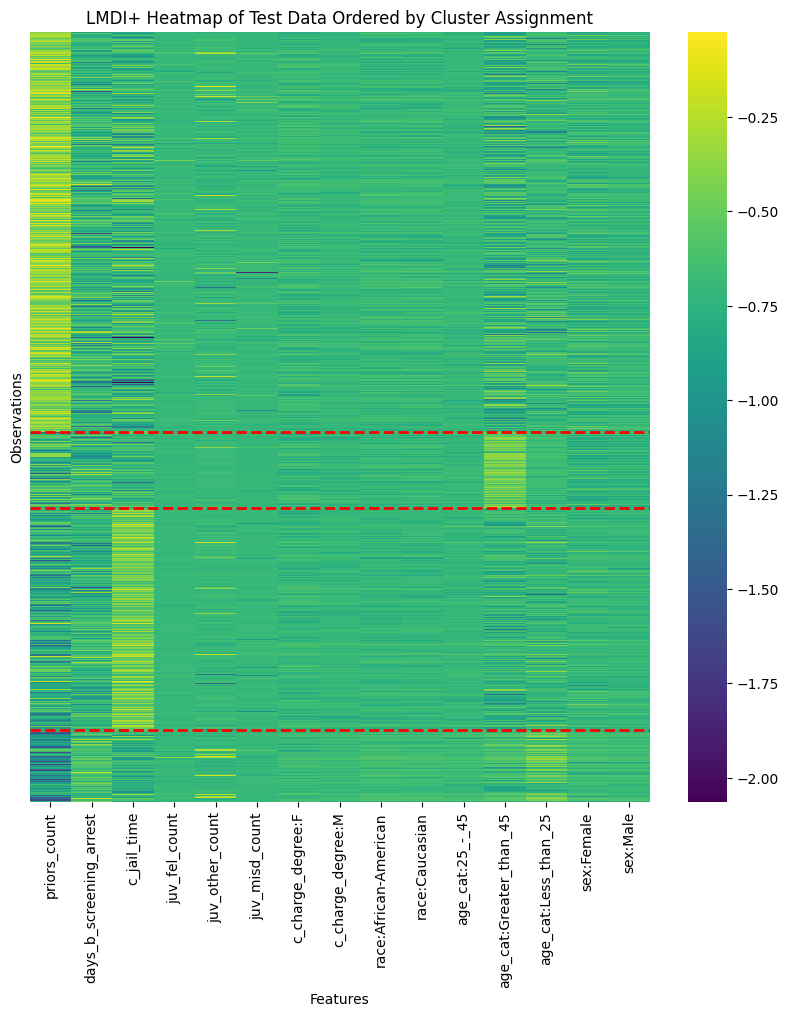

In [27]:
# create new heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(mdi_test_clust, cmap='viridis')
plt.xlabel('Features')
plt.ylabel('Observations')
plt.title('LMDI+ Heatmap of Test Data Ordered by Cluster Assignment')
plt.yticks([])
plt.xticks(np.arange(len(X.columns)) + 0.5, X.columns, rotation = 90)
# put horizontal lines where cluster membership changes
for i in cluster_changes:
    plt.axhline(i, color='red', linewidth=2, linestyle='--')
plt.show()

In [28]:
# get most important feature on average for each cluster
for i in range(num_clusters):
    print(f'The most important feature for Train Cluster #{i+1} is:', X.columns[np.argmax(np.mean(mdi[clusters==i+1], axis=0))])
    print(f'The most important feature for Test Cluster #{i+1} is:', X.columns[np.argmax(np.mean(mdi_test[test_clust==i+1], axis=0))])

The most important feature for Train Cluster #1 is: priors_count
The most important feature for Test Cluster #1 is: priors_count
The most important feature for Train Cluster #2 is: age_cat:Greater_than_45
The most important feature for Test Cluster #2 is: age_cat:Greater_than_45
The most important feature for Train Cluster #3 is: c_jail_time
The most important feature for Test Cluster #3 is: c_jail_time
The most important feature for Train Cluster #4 is: age_cat:Less_than_25
The most important feature for Test Cluster #4 is: age_cat:Less_than_25


In [29]:
for i in range(num_clusters):
    # negative is taken because argsort goes in the wrong order
    print(f'The feature ranking for Train Cluster #{i+1} is:', list(X.columns[np.argsort(-np.mean(mdi[clusters==i+1], axis=0))]))
    print(f'The feature ranking for Test Cluster #{i+1} is:', list(X.columns[np.argsort(-np.mean(mdi_test[test_clust==i+1], axis=0))]))

The feature ranking for Train Cluster #1 is: ['priors_count', 'juv_fel_count', 'sex:Female', 'c_charge_degree:F', 'race:Caucasian', 'race:African-American', 'c_charge_degree:M', 'juv_misd_count', 'sex:Male', 'juv_other_count', 'age_cat:25_-_45', 'age_cat:Less_than_25', 'age_cat:Greater_than_45', 'days_b_screening_arrest', 'c_jail_time']
The feature ranking for Test Cluster #1 is: ['priors_count', 'juv_other_count', 'juv_fel_count', 'race:Caucasian', 'c_charge_degree:F', 'juv_misd_count', 'race:African-American', 'c_charge_degree:M', 'sex:Female', 'age_cat:25_-_45', 'sex:Male', 'age_cat:Less_than_25', 'c_jail_time', 'age_cat:Greater_than_45', 'days_b_screening_arrest']
The feature ranking for Train Cluster #2 is: ['age_cat:Greater_than_45', 'age_cat:25_-_45', 'juv_misd_count', 'juv_fel_count', 'juv_other_count', 'race:Caucasian', 'age_cat:Less_than_25', 'c_charge_degree:F', 'race:African-American', 'c_charge_degree:M', 'sex:Male', 'sex:Female', 'days_b_screening_arrest', 'c_jail_time', 

# TreeSHAP

To detect subgroups using TreeSHAP, we obtain the TreeSHAP scores from the fitted random forest that was given to the RF+ constructor. We then convert these importance scores to feature rankings and compute RBO, which is the same process we underwent for Local MDI+. The resulting clusters can be visualized below. It is worth noting that we evaluate the RF here instead of the RF+. This is due to two reasons: TreeSHAP is made for RFs, not RF+s, and the clusters made by TreeSHAP are too small to fit RF+s (due to cross-validation).

In [30]:
# compute r^2 on the test set
y_pred = rf.predict(X_test)
global_acc = np.mean(y_test == y_pred)
print(f'RF Test Set Accuracy: {np.mean(y_test == y_pred)}')
global_misclassified = np.sum(y_test != y_pred)
print(f'RF Test Set Misclassified: {np.sum(y_test != y_pred)}')

RF Test Set Accuracy: 0.6193181818181818
RF Test Set Misclassified: 603


In [31]:
explainer = shap.TreeExplainer(rf)

In [32]:
shap_values = np.abs(explainer.shap_values(X_train, check_additivity=False))

In [33]:
shap_rankings = mdi_explainer.get_rankings(shap_values)[:,:,0]

In [34]:
shap_rankings.shape

(3694, 15)

In [35]:
# get rbo distance matrix
rbo_train = compute_rbo_matrix(shap_rankings, form = 'distance')

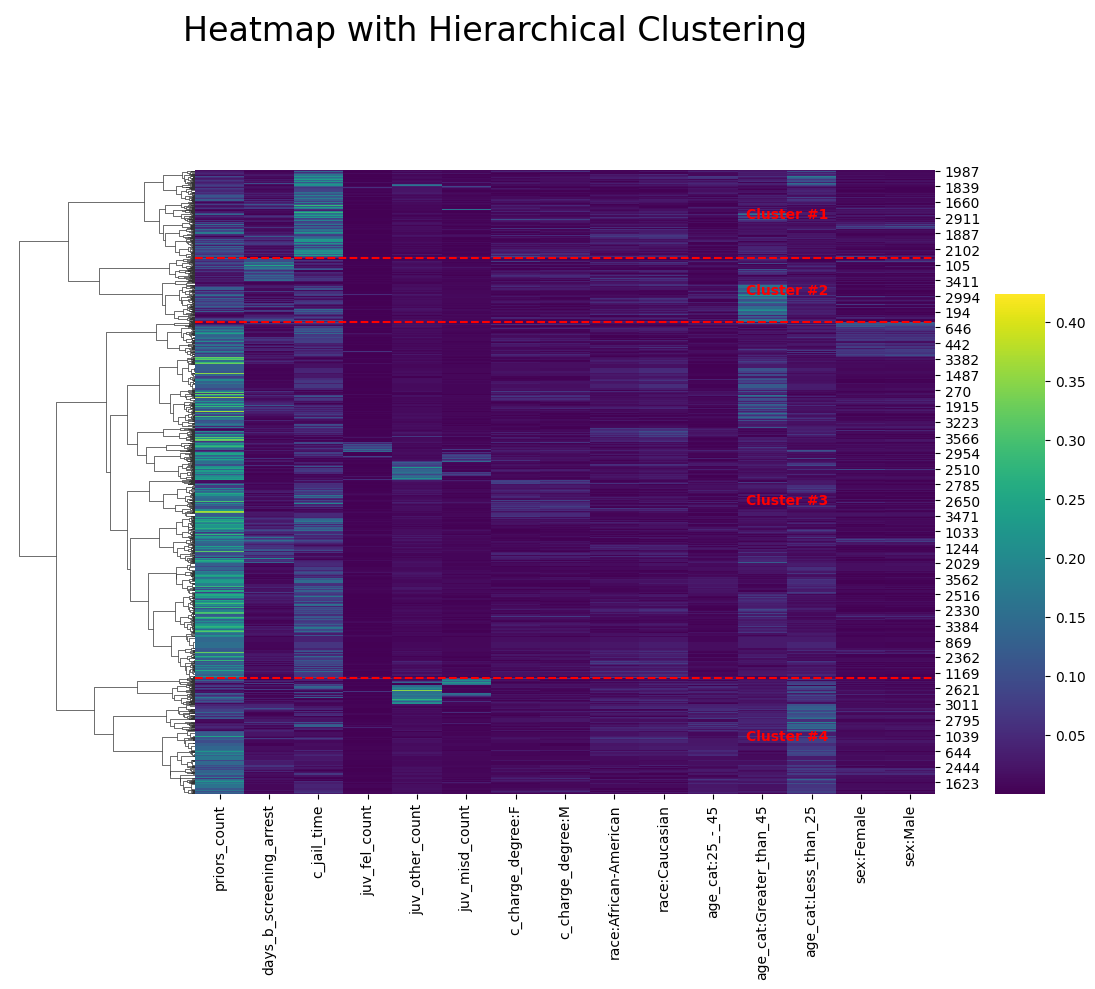

In [36]:
shap_copy = pd.DataFrame(shap_values[:,:,0], columns=X.columns).copy()
num_clusters = 4
clusters = assign_training_clusters(shap_copy, rbo_train, num_clusters)

We now check some summary statistics of the above clusters. It is worth noting that the subgroups that are 'discovered' by TreeSHAP either are composed entirely of smokers or of non-smokers.

In [37]:
print("---------------------------------------------")
# calculate average charge for each cluster
for i in range(num_clusters):
    print(f"Proportion of Data in Cluster #{i+1}:",
          X_train[clusters==i+1].shape[0]/X_train.shape[0])
print("---------------------------------------------")
# get average number of priors in each cluster
for i in range(num_clusters):
    print(f"Average # of Priors in Cluster #{i+1}:",
          X_train[clusters==i+1]['priors_count'].mean())
print("---------------------------------------------")
# get average # of days before screening arrest in each cluster
for i in range(num_clusters):
    print(f"Average # of Days Before Screening Arrest in Cluster #{i+1}:",
          X_train[clusters==i+1]['days_b_screening_arrest'].mean())
print("---------------------------------------------")
# get average jail time in each cluster
for i in range(num_clusters):
    print(f"Average Jail Time (Days) in Cluster #{i+1}:",
          X_train[clusters==i+1]['c_jail_time'].mean())
print("---------------------------------------------")
# get average # of juvenile felony counts in each cluster
for i in range(num_clusters):
    print(f"Average # of Juvenile Felony Counts in Cluster #{i+1}:",
          X_train[clusters==i+1]['juv_fel_count'].mean())
print("---------------------------------------------")
# get average number juvenile 'other' counts in each cluster
for i in range(num_clusters):
    print(f"Average # of Juvenile 'Other' Counts in Cluster #{i+1}:",
          X_train[clusters==i+1]['juv_other_count'].mean())
print("---------------------------------------------")
# get average number of juvenile misdemeanor counts in each cluster
for i in range(num_clusters):
    print(f"Average # of Juvenile Misdemeanor Counts in Cluster #{i+1}:",
          X_train[clusters==i+1]['juv_misd_count'].mean())
print("---------------------------------------------")
# get probability of felony charge in each cluster
for i in range(num_clusters):
    print(f"Probability of Felony Charge in Cluster #{i+1}:",
          X_train[clusters==i+1]['c_charge_degree:F'].mean())
print("---------------------------------------------")
# get proportion of African-American defendants in each cluster
for i in range(num_clusters):
    print(f"Proportion of African-American Defendants in Cluster #{i+1}:",
          X_train[clusters==i+1]['race:African-American'].mean())
print("---------------------------------------------")
# get proportion of age 25-45 in each cluster
for i in range(num_clusters):
    print(f"Proportion of Defendants Aged 25-45 in Cluster #{i+1}:",
          X_train[clusters==i+1]['age_cat:25_-_45'].mean())
print("---------------------------------------------")
# get proportion of age over 45 in each cluster
for i in range(num_clusters):
    print(f"Proportion of Defendants Over Age 45 in Cluster #{i+1}:",
          X_train[clusters==i+1]['age_cat:Greater_than_45'].mean())
print("---------------------------------------------")
# get proportion of age under 25 in each cluster
for i in range(num_clusters):
    print(f"Proportion of Defendants Under Age 25 in Cluster #{i+1}:",
          X_train[clusters==i+1]['age_cat:Less_than_25'].mean())
print("---------------------------------------------")
# get proportion of men in each cluster
for i in range(num_clusters):
    print(f"Proportion of Men in Cluster #{i+1}:",
          X_train[clusters==i+1]['sex:Male'].mean())
# get proportion of smokers in each cluster
for i in range(num_clusters):
    print(f"Probability of Recidivism in Cluster #{i+1}:",
          y_train[clusters==i+1].mean())
print("---------------------------------------------")

---------------------------------------------
Proportion of Data in Cluster #1: 0.14076881429344884
Proportion of Data in Cluster #2: 0.10205739036275041
Proportion of Data in Cluster #3: 0.5720086626962642
Proportion of Data in Cluster #4: 0.18516513264753653
---------------------------------------------
Average # of Priors in Cluster #1: 2.7576923
Average # of Priors in Cluster #2: 3.1803713
Average # of Priors in Cluster #3: 4.3932796
Average # of Priors in Cluster #4: 1.4532164
---------------------------------------------
Average # of Days Before Screening Arrest in Cluster #1: -2.125
Average # of Days Before Screening Arrest in Cluster #2: -5.3501325
Average # of Days Before Screening Arrest in Cluster #3: -1.3166114
Average # of Days Before Screening Arrest in Cluster #4: -0.99122804
---------------------------------------------
Average Jail Time (Days) in Cluster #1: 23.948076
Average Jail Time (Days) in Cluster #2: 9.787799
Average Jail Time (Days) in Cluster #3: 13.917179
Ave

## Evaluating Cluster Performance - Centroid Method w/ Exact Mean
Now that we have a good idea of what our clustering has done, we can check if this helps improve our predictions. We will take the test points and determine their cluster membership based on their RBO similarity to the mean point in each cluster (in RBO embedding). We will then fit a RF+ on the training data and using it to predict the test data for that cluster. We can then compute the R^2 and total squared error for each cluster's model. By summing the TSE across cluster models and comparing this to the original TSE reported above, we can get a good idea of how well these clusters improve model accuracy.

In [38]:
# get mdi rankings assignments for test points
shap_test_values = np.abs(explainer.shap_values(X_test, check_additivity=False))
shap_test_rankings = mdi_explainer.get_rankings(shap_test_values)[:,:,0]

In [39]:
test_clust = assign_testing_clusters(method = "centroid", median_approx = False,
                                     rbo_distance_matrix = rbo_train,
                                     lfi_train_ranking = shap_rankings,
                                     lfi_test_ranking = shap_test_rankings,
                                     clusters = clusters)

In [40]:
cluster1_trainX = X_train[clusters == 1]
cluster2_trainX = X_train[clusters == 2]
cluster3_trainX = X_train[clusters == 3]
cluster4_trainX = X_train[clusters == 4]

cluster1_trainy = y_train[clusters == 1]
cluster2_trainy = y_train[clusters == 2]
cluster3_trainy = y_train[clusters == 3]
cluster4_trainy = y_train[clusters == 4]

cluster1_testX = X_test[test_clust == 1]
cluster2_testX = X_test[test_clust == 2]
cluster3_testX = X_test[test_clust == 3]
cluster4_testX = X_test[test_clust == 4]

cluster1_testy = y_test[test_clust == 1]
cluster2_testy = y_test[test_clust == 2]
cluster3_testy = y_test[test_clust == 3]
cluster4_testy = y_test[test_clust == 4]

In [41]:
print("---------------------------------------------")
# calculate average charge for each cluster
for i in range(num_clusters):
    print(f"Proportion of Train Data in Cluster #{i+1}:",
          X_train[clusters==i+1].shape[0]/X_train.shape[0])
    print(f"Proportion of Test Data in Cluster #{i+1}:",
          X_test[test_clust==i+1].shape[0]/X_test.shape[0])
print("---------------------------------------------")
# get average number of priors in each cluster
for i in range(num_clusters):
    print(f"Average # of Priors in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['priors_count'].mean())
    print(f"Average # of Priors in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['priors_count'].mean())
print("---------------------------------------------")
# get average # of days before screening arrest in each cluster
for i in range(num_clusters):
    print(f"Average # of Days Before Screening Arrest in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['days_b_screening_arrest'].mean())
    print(f"Average # of Days Before Screening Arrest in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['days_b_screening_arrest'].mean())
print("---------------------------------------------")
# get average jail time in each cluster
for i in range(num_clusters):
    print(f"Average Jail Time (Days) in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['c_jail_time'].mean())
    print(f"Average Jail Time (Days) in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['c_jail_time'].mean())
print("---------------------------------------------")
# get average # of juvenile felony counts in each cluster
for i in range(num_clusters):
    print(f"Average # of Juvenile Felony Counts in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['juv_fel_count'].mean())
    print(f"Average # of Juvenile Felony Counts in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['juv_fel_count'].mean())
print("---------------------------------------------")
# get average number juvenile 'other' counts in each cluster
for i in range(num_clusters):
    print(f"Average # of Juvenile 'Other' Counts in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['juv_other_count'].mean())
    print(f"Average # of Juvenile 'Other' Counts in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['juv_other_count'].mean())
print("---------------------------------------------")
# get average number of juvenile misdemeanor counts in each cluster
for i in range(num_clusters):
    print(f"Average # of Juvenile Misdemeanor Counts in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['juv_misd_count'].mean())
    print(f"Average # of Juvenile Misdemeanor Counts in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['juv_misd_count'].mean())
print("---------------------------------------------")
# get probability of felony charge in each cluster
for i in range(num_clusters):
    print(f"Probability of Felony Charge in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['c_charge_degree:F'].mean())
    print(f"Probability of Felony Charge in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['c_charge_degree:F'].mean())
print("---------------------------------------------")
# get proportion of African-American defendants in each cluster
for i in range(num_clusters):
    print(f"Proportion of African-American Defendants in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['race:African-American'].mean())
    print(f"Proportion of African-American Defendants in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['race:African-American'].mean())
print("---------------------------------------------")
# get proportion of age 25-45 in each cluster
for i in range(num_clusters):
    print(f"Proportion of Defendants Aged 25-45 in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['age_cat:25_-_45'].mean())
    print(f"Proportion of Defendants Aged 25-45 in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['age_cat:25_-_45'].mean())
print("---------------------------------------------")
# get proportion of age over 45 in each cluster
for i in range(num_clusters):
    print(f"Proportion of Defendants Over Age 45 in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['age_cat:Greater_than_45'].mean())
    print(f"Proportion of Defendants Over Age 45 in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['age_cat:Greater_than_45'].mean())
print("---------------------------------------------")
# get proportion of age under 25 in each cluster
for i in range(num_clusters):
    print(f"Proportion of Defendants Under Age 25 in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['age_cat:Less_than_25'].mean())
    print(f"Proportion of Defendants Under Age 25 in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['age_cat:Less_than_25'].mean())
print("---------------------------------------------")
# get proportion of men in each cluster
for i in range(num_clusters):
    print(f"Proportion of Men in Train Cluster #{i+1}:",
          X_train[clusters==i+1]['sex:Male'].mean())
    print(f"Proportion of Men in Test Cluster #{i+1}:",
          X_test[test_clust==i+1]['sex:Male'].mean())
# get proportion of smokers in each cluster
for i in range(num_clusters):
    print(f"Probability of Recidivism in Train Cluster #{i+1}:",
          y_train[clusters==i+1].mean())
    print(f"Probability of Recidivism in Test Cluster #{i+1}:",
          y_test[test_clust==i+1].mean())
print("---------------------------------------------")

---------------------------------------------
Proportion of Train Data in Cluster #1: 0.14076881429344884
Proportion of Test Data in Cluster #1: 0.13952020202020202
Proportion of Train Data in Cluster #2: 0.10205739036275041
Proportion of Test Data in Cluster #2: 0.09911616161616162
Proportion of Train Data in Cluster #3: 0.5720086626962642
Proportion of Test Data in Cluster #3: 0.5858585858585859
Proportion of Train Data in Cluster #4: 0.18516513264753653
Proportion of Test Data in Cluster #4: 0.1755050505050505
---------------------------------------------
Average # of Priors in Train Cluster #1: 2.7576923
Average # of Priors in Test Cluster #1: 2.3755655
Average # of Priors in Train Cluster #2: 3.1803713
Average # of Priors in Test Cluster #2: 2.3057325
Average # of Priors in Train Cluster #3: 4.3932796
Average # of Priors in Test Cluster #3: 4.380388
Average # of Priors in Train Cluster #4: 1.4532164
Average # of Priors in Test Cluster #4: 1.4676259
--------------------------------

In [42]:
%%capture
# fit RF+ on each training set, predict test
rf1 = RandomForestClassifier(n_estimators=100, random_state=0)
rf1.fit(cluster1_trainX, cluster1_trainy)

rf2 = RandomForestClassifier(n_estimators=100, random_state=0)
rf2.fit(cluster2_trainX, cluster2_trainy)

rf3 = RandomForestClassifier(n_estimators=100, random_state=0)
rf3.fit(cluster3_trainX, cluster3_trainy)

rf4 = RandomForestClassifier(n_estimators=100, random_state=0)
rf4.fit(cluster4_trainX, cluster4_trainy)

In [43]:
print("---------------------------------------------")
y_pred1 = rf1.predict(cluster1_testX)
acc1l = np.mean(cluster1_testy == y_pred1)
mis1l = np.sum(cluster1_testy != y_pred1)
y_pred1g = rf.predict(cluster1_testX)
acc1g = np.mean(cluster1_testy == y_pred1g)
mis1g = np.sum(cluster1_testy != y_pred1g)
y_pred_prob1 = rf1.predict_proba(cluster1_testX)[:, 1]
auroc1l = roc_auc_score(cluster1_testy, y_pred_prob1)
auprc1l = average_precision_score(cluster1_testy, y_pred_prob1)
f1_1l = f1_score(cluster1_testy, y_pred1)
y_pred_prob1g = rf.predict_proba(cluster1_testX)[:, 1]
auroc1g = roc_auc_score(cluster1_testy, y_pred_prob1g)
auprc1g = average_precision_score(cluster1_testy, y_pred_prob1g)
f1_1g = f1_score(cluster1_testy, y_pred1g)
print(f'Local RF Cluster #1 Test Set Accuracy: {acc1l}')
print(f'Local RF Cluster #1 Test Set # Misclassified: {mis1l}')
print(f'Local RF Cluster #1 Test Set AUROC: {auroc1l}')
print(f'Local RF Cluster #1 Test Set AUPRC: {auprc1l}')
print(f'Local RF Cluster #1 Test Set F1 Score: {f1_1l}')
print(f'Global RF Cluster #1 Test Set Accuracy: {acc1g}')
print(f'Global RF Cluster #1 Test Set # Misclassified: {mis1g}')
print(f'Global RF Cluster #1 Test Set AUROC: {auroc1g}')
print(f'Global RF Cluster #1 Test Set AUPRC: {auprc1g}')
print(f'Global RF Cluster #1 Test Set F1 Score: {f1_1g}')
print("---------------------------------------------")
y_pred2 = rf2.predict(cluster2_testX)
acc2l = np.mean(cluster2_testy == y_pred2)
mis2l = np.sum(cluster2_testy != y_pred2)
y_pred2g = rf.predict(cluster2_testX)
acc2g = np.mean(cluster2_testy == y_pred2g)
mis2g = np.sum(cluster2_testy != y_pred2g)
y_pred_prob2 = rf2.predict_proba(cluster2_testX)[:, 1]
auroc2l = roc_auc_score(cluster2_testy, y_pred_prob2)
auprc2l = average_precision_score(cluster2_testy, y_pred_prob2)
f1_2l = f1_score(cluster2_testy, y_pred2)
y_pred_prob2g = rf.predict_proba(cluster2_testX)[:, 1]
auroc2g = roc_auc_score(cluster2_testy, y_pred_prob2g)
auprc2g = average_precision_score(cluster2_testy, y_pred_prob2g)
f1_2g = f1_score(cluster2_testy, y_pred2g)
print(f'Local RF Cluster #2 Test Set Accuracy: {acc2l}')
print(f'Local RF Cluster #2 Test Set # Misclassified: {mis2l}')
print(f'Local RF Cluster #2 Test Set AUROC: {auroc2l}')
print(f'Local RF Cluster #2 Test Set AUPRC: {auprc2l}')
print(f'Local RF Cluster #2 Test Set F1 Score: {f1_2l}')
print(f'Global RF Cluster #2 Test Set Accuracy: {acc2g}')
print(f'Global RF Cluster #2 Test Set # Misclassified: {mis2g}')
print(f'Global RF Cluster #2 Test Set AUROC: {auroc2g}')
print(f'Global RF Cluster #2 Test Set AUPRC: {auprc2g}')
print(f'Global RF Cluster #2 Test Set F1 Score: {f1_2g}')
print("---------------------------------------------")
y_pred3 = rf1.predict(cluster3_testX)
acc3l = np.mean(cluster3_testy == y_pred3)
mis3l = np.sum(cluster3_testy != y_pred3)
y_pred3g = rf.predict(cluster3_testX)
acc3g = np.mean(cluster3_testy == y_pred3g)
mis3g = np.sum(cluster3_testy != y_pred3g)
y_pred_prob3 = rf3.predict_proba(cluster3_testX)[:, 1]
auroc3l = roc_auc_score(cluster3_testy, y_pred_prob3)
auprc3l = average_precision_score(cluster3_testy, y_pred_prob3)
f1_3l = f1_score(cluster3_testy, y_pred3)
y_pred_prob3g = rf.predict_proba(cluster3_testX)[:, 1]
auroc3g = roc_auc_score(cluster3_testy, y_pred_prob3g)
auprc3g = average_precision_score(cluster3_testy, y_pred_prob3g)
f1_3g = f1_score(cluster3_testy, y_pred3g)
print(f'Local RF Cluster #3 Test Set Accuracy: {acc3l}')
print(f'Local RF Cluster #3 Test Set # Misclassified: {mis3l}')
print(f'Local RF Cluster #3 Test Set AUROC: {auroc3l}')
print(f'Local RF Cluster #3 Test Set AUPRC: {auprc3l}')
print(f'Local RF Cluster #3 Test Set F1 Score: {f1_3l}')
print(f'Global RF Cluster #3 Test Set Accuracy: {acc3g}')
print(f'Global RF Cluster #3 Test Set # Misclassified: {mis3g}')
print(f'Global RF Cluster #3 Test Set AUROC: {auroc3g}')
print(f'Global RF Cluster #3 Test Set AUPRC: {auprc3g}')
print(f'Global RF Cluster #3 Test Set F1 Score: {f1_3g}')
print("---------------------------------------------")
y_pred4 = rf4.predict(cluster4_testX)
acc4l = np.mean(cluster4_testy == y_pred4)
mis4l = np.sum(cluster4_testy != y_pred4)
y_pred4g = rf.predict(cluster4_testX)
acc4g = np.mean(cluster4_testy == y_pred4g)
mis4g = np.sum(cluster4_testy != y_pred4g)
y_pred_prob4 = rf4.predict_proba(cluster4_testX)[:, 1]
auroc4l = roc_auc_score(cluster4_testy, y_pred_prob4)
auprc4l = average_precision_score(cluster4_testy, y_pred_prob4)
f1_4l = f1_score(cluster4_testy, y_pred4)
y_pred_prob4g = rf.predict_proba(cluster4_testX)[:, 1]
auroc4g = roc_auc_score(cluster4_testy, y_pred_prob4g)
auprc4g = average_precision_score(cluster4_testy, y_pred_prob4g)
f1_4g = f1_score(cluster4_testy, y_pred4g)
print(f'Local RF Cluster #4 Test Set Accuracy: {acc4l}')
print(f'Local RF Cluster #4 Test Set # Misclassified: {mis4l}')
print(f'Local RF Cluster #4 Test Set AUROC: {auroc4l}')
print(f'Local RF Cluster #4 Test Set AUPRC: {auprc4l}')
print(f'Local RF Cluster #4 Test Set F1 Score: {f1_4l}')
print(f'Global RF Cluster #4 Test Set Accuracy: {acc4g}')
print(f'Global RF Cluster #4 Test Set # Misclassified: {mis4g}')
print(f'Global RF Cluster #4 Test Set AUROC: {auroc4g}')
print(f'Global RF Cluster #4 Test Set AUPRC: {auprc4g}')
print(f'Global RF Cluster #4 Test Set F1 Score: {f1_4g}')
print("---------------------------------------------")

---------------------------------------------
Local RF Cluster #1 Test Set Accuracy: 0.4479638009049774
Local RF Cluster #1 Test Set # Misclassified: 122
Local RF Cluster #1 Test Set AUROC: 0.44040196882690735
Local RF Cluster #1 Test Set AUPRC: 0.4942416166089245
Local RF Cluster #1 Test Set F1 Score: 0.5378787878787878
Global RF Cluster #1 Test Set Accuracy: 0.4796380090497738
Global RF Cluster #1 Test Set # Misclassified: 115
Global RF Cluster #1 Test Set AUROC: 0.508777686628384
Global RF Cluster #1 Test Set AUPRC: 0.5739333314313575
Global RF Cluster #1 Test Set F1 Score: 0.5106382978723404
---------------------------------------------
Local RF Cluster #2 Test Set Accuracy: 0.5796178343949044
Local RF Cluster #2 Test Set # Misclassified: 66
Local RF Cluster #2 Test Set AUROC: 0.48970944309927367
Local RF Cluster #2 Test Set AUPRC: 0.41647824148913437
Local RF Cluster #2 Test Set F1 Score: 0.2826086956521739
Global RF Cluster #2 Test Set Accuracy: 0.5859872611464968
Global RF Clust

In [44]:
print("---------------------------------------------")
print("Total # of Observations Predicted by Global Model:", X_test.shape[0])
print("Total # of Observations Predicted by Cluster Models:",
      cluster1_testX.shape[0] + cluster2_testX.shape[0] + \
          cluster3_testX.shape[0] + cluster4_testX.shape[0])
print("---------------------------------------------")
print("Difference in # Misclassified (Global - Sum of Clusters):", round(global_misclassified - (mis1l + mis2l + mis3l + mis4l), 2))
print(f"Percent Improvement Over Global Model: {round(100*(global_misclassified - (mis1l + mis2l + mis3l + mis4l))/global_misclassified, 2)}%")
print("---------------------------------------------")

---------------------------------------------
Total # of Observations Predicted by Global Model: 1584
Total # of Observations Predicted by Cluster Models: 1584
---------------------------------------------
Difference in # Misclassified (Global - Sum of Clusters): -120
Percent Improvement Over Global Model: -19.9%
---------------------------------------------


In [45]:
# order rows of mdi_test by cluster assignment
shap_test_clust = shap_test_values[np.argsort(test_clust)]

In [46]:
# order test clust by cluster assignment
shap_test_clust_org = test_clust[np.argsort(test_clust)]

In [47]:
# get indexes where mdi_test_clust changes clusters
cluster_changes = np.where(np.diff(shap_test_clust_org) != 0)[0]

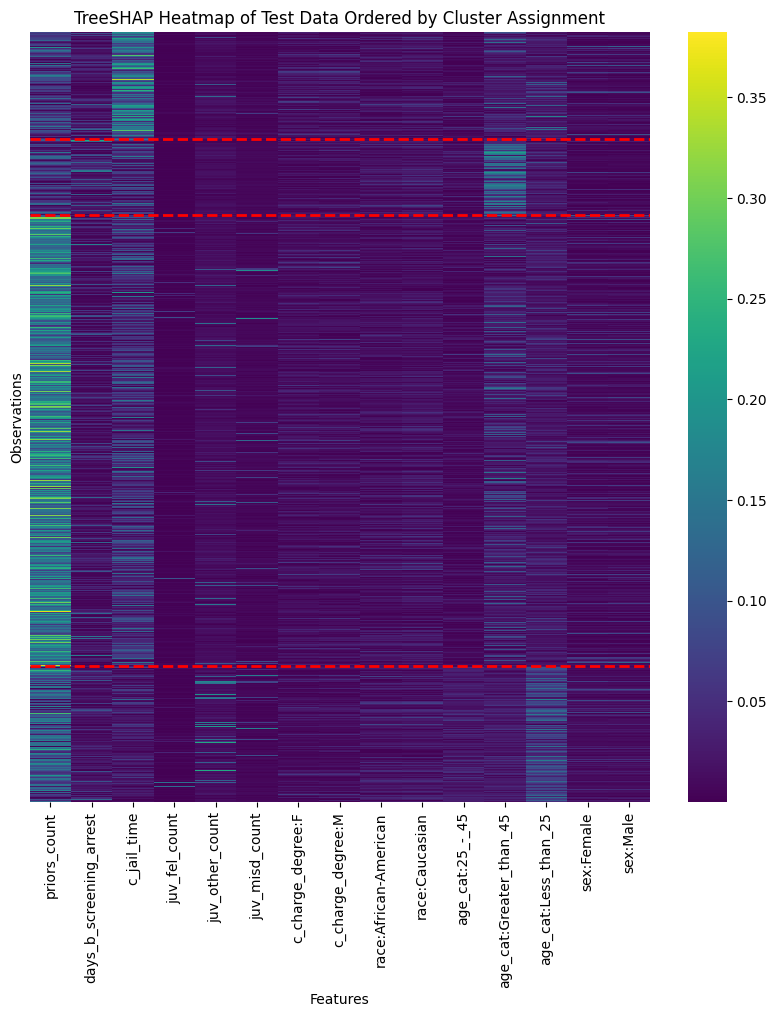

In [48]:
# create new heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(shap_test_clust[:,:,0], cmap='viridis')
plt.xlabel('Features')
plt.ylabel('Observations')
plt.title('TreeSHAP Heatmap of Test Data Ordered by Cluster Assignment')
plt.yticks([])
plt.xticks(np.arange(len(X.columns)) + 0.5, X.columns, rotation=90)
# put horizontal lines where cluster membership changes
for i in cluster_changes:
    plt.axhline(i, color='red', linewidth=2, linestyle='--')
plt.show()

In [49]:
# get most important feature on average for each cluster
for i in range(num_clusters):
    print(f'The most important feature for Train Cluster #{i+1} is:', X.columns[np.argmax(np.mean(shap_values[:,:,0][clusters==i+1], axis=0))])
    print(f'The most important feature for Test Cluster #{i+1} is:', X.columns[np.argmax(np.mean(shap_test_values[:,:,0][test_clust==i+1], axis=0))])

The most important feature for Train Cluster #1 is: c_jail_time
The most important feature for Test Cluster #1 is: c_jail_time
The most important feature for Train Cluster #2 is: age_cat:Greater_than_45
The most important feature for Test Cluster #2 is: age_cat:Greater_than_45
The most important feature for Train Cluster #3 is: priors_count
The most important feature for Test Cluster #3 is: priors_count
The most important feature for Train Cluster #4 is: priors_count
The most important feature for Test Cluster #4 is: priors_count


In [50]:
for i in range(num_clusters):
    # negative is taken because argsort goes in the wrong order
    print(f'The feature ranking for Train Cluster #{i+1} is:', list(X.columns[np.argsort(-np.mean(shap_values[:,:,0][clusters==i+1], axis=0))]))
    print(f'The feature ranking for Test Cluster #{i+1} is:', list(X.columns[np.argsort(-np.mean(shap_test_values[:,:,0][test_clust==i+1], axis=0))]))

The feature ranking for Train Cluster #1 is: ['c_jail_time', 'priors_count', 'age_cat:Less_than_25', 'age_cat:Greater_than_45', 'days_b_screening_arrest', 'race:Caucasian', 'race:African-American', 'c_charge_degree:F', 'c_charge_degree:M', 'juv_other_count', 'age_cat:25_-_45', 'sex:Male', 'sex:Female', 'juv_misd_count', 'juv_fel_count']
The feature ranking for Test Cluster #1 is: ['c_jail_time', 'priors_count', 'age_cat:Less_than_25', 'age_cat:Greater_than_45', 'days_b_screening_arrest', 'c_charge_degree:M', 'c_charge_degree:F', 'race:Caucasian', 'race:African-American', 'juv_other_count', 'sex:Female', 'sex:Male', 'age_cat:25_-_45', 'juv_misd_count', 'juv_fel_count']
The feature ranking for Train Cluster #2 is: ['age_cat:Greater_than_45', 'days_b_screening_arrest', 'priors_count', 'c_jail_time', 'age_cat:Less_than_25', 'race:Caucasian', 'race:African-American', 'c_charge_degree:F', 'c_charge_degree:M', 'age_cat:25_-_45', 'juv_other_count', 'sex:Female', 'sex:Male', 'juv_misd_count', '